In [1]:
!pip install git+https://github.com/robgon-art/dalle-mini.git
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

import jax
import jax.numpy as jnp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/robgon-art/dalle-mini.git to /tmp/pip-req-build-58vkufod
  Running command git clone -q https://github.com/robgon-art/dalle-mini.git /tmp/pip-req-build-58vkufod
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.9 MB 31.9 MB/s 
     |████████████████████████████████| 180 kB 11.7 MB/s 
     |████████████████████████████████| 53 kB 366 kB/s 
     |████████████████████████████████| 197 kB 76.6 MB/s 
     |████████████████████████████████| 235 kB 65.6 MB/s 
     |████████████████████████████████| 1.8 MB 59.1 MB/s 
     |████████████████████████████████| 217 kB 69.2 MB/s 
     |████████████████████████████████| 145 kB 48.8 MB/s 
     |████████████████████████████████| 51 kB 8.6 MB/s 
     |████████████████████████████████| 85 kB 4.6 MB/s 
     |█████

In [2]:
#@title Choose DALL-E Model

choose_model = "DALL-E Mini" #@param ["DALL-E Mini", "DALL-E Mega", "DALL-E Mega Full"]

models = {"DALL-E Mini":"dalle-mini/dalle-mini/mini-1:v0",
          "DALL-E Mega":"dalle-mini/dalle-mini/mega-1-fp16:latest",
          "DALL-E Mega Full":"dalle-mini/dalle-mini/mega-1:latest"}

DALLE_COMMIT_ID = None

DALLE_MODEL = models[choose_model]

VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

from functools import partial

@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )

@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:39.4


Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/304M [00:00<?, ?B/s]

wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:9.3


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/jax/_src/ops/scatter.py:90: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float16 to dtype=float32. In future JAX releases this will result in an error.
  FutureWarning)


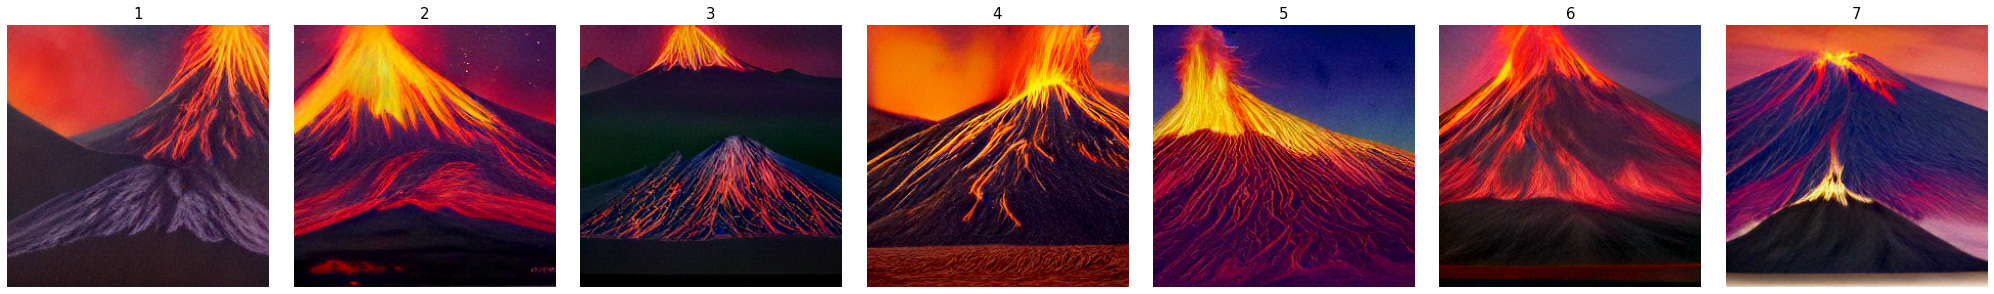

volcano painting


In [3]:
#@title Generate Images

import matplotlib.pyplot as plt
import random

prompt = 'volcano painting' #@param {type:"string"}
prompts = [prompt]
tokenized_prompts = processor(prompts)
tokenized_prompt = replicate(tokenized_prompts)

seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

n_predictions = 7

gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    key, subkey = jax.random.split(key)
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    encoded_images = encoded_images.sequences[..., 1:]
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)

cols = n_predictions
index = 0
fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(cols*4, 4))
for i in range(cols):
  axes[i].axis("off")
  axes[i].set_title(str(index+1), fontsize=15)  
  axes[i].imshow(images[index])
  index += 1

fig.tight_layout()
plt.show()
print(prompt)

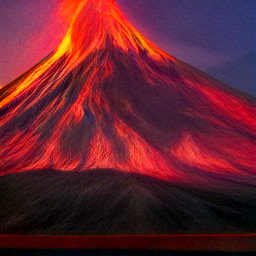

In [4]:
choose = 6
from IPython.display import Image
images[choose-1].save("output.png")
Image('output.png')